In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import logging
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt


import pudl

from pudl.analysis.allocate_net_gen import *

mpl.style.use('dark_background')
pd.options.display.max_columns = None
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Implementation Zone for Allocating Fuel

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
# the fill_net_gen arg is employing a beta feature!
# It will result in a much higher coverage of net generation
# and fuel consuption, but it has known issues with multi-fuel plants.
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine,
    freq='AS',
    fill_fuel_cost=True,
    roll_fuel_cost=True,
    fill_net_gen=False,
)

In [5]:
# make sure the net generation allocation still functions w/ the fuel changes
gen_alloc = pudl_out.gen_allocated_eia923()

Removing 3621 generators that retired mid-year out of 403832


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/pandas/core/missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


No records found with fuel-only records. This is expected.
Ratio calc types: 
   All gens w/in generation table:  65275#, 1.1e+07 MW
   Some gens w/in generation table: 2395#, 1.7e+05 MW
   No gens w/in generation table:   359948#, 1.7e+07 MW
   GF table records have no PM:     0#


/Users/christinagosnell/code/pudl/src/pudl/analysis/allocate_net_gen.py:843: UserWarning: Ooopsies. You got 100 records where the 'frac' column isn't adding up to 1 for each 'IDX_PM_FUEL' group. Check 'make_allocation_frac()'
  warnings.warn(


1.958% of records have are partially off from their 'IDX_PM_FUEL' group
new v fuel table net gen diff:      98.7%


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/pandas/core/missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


9.11% of generator records are more that 5% off from the net generation table


## Common Inputs Between Net Gen and Fuel Allocation

In [5]:
IDX_U = ['plant_id_eia', 'unit_id_pudl', 'report_date']

def remove_nulled_units_from_bf(bf_all):
    bf_null = bf_all.loc[
        bf_all.fuel_consumed_mmbtu.isnull()
        #| (bf_all.fuel_consumed_mmbtu == 0)
    ]
    nulllss = len(bf_null[IDX_U].drop_duplicates())/len(bf_all[IDX_U].drop_duplicates())
    logger.info(f"{nulllss:.1%} of BF annual units have null data.")

    bf_new = bf_all.set_index(IDX_U).drop(bf_null.set_index(IDX_U).index).reset_index()
    logger.info(
        f"Removed {1- len(bf_new)/len(bf_all):.1%} of BF records due to nulls within units. \n"
        f"Removed {1- bf_new.fuel_consumed_mmbtu.sum()/bf_all.fuel_consumed_mmbtu.sum():.1%} of BF fuel due to nulls within units."
    )
    return bf_new

def remove_off_msw_fuels(df, idx):
    logger.info(len(df))
    df = df.replace({'fuel_type': {"MSN": "MSW","MSB": "MSW"}})
    df = df.groupby(idx, as_index=False, dropna=False).sum(min_count=1)
    logger.info(len(df))
    return df

# extract all of the tables from pudl_out early in the process and select
# only the columns we need. this is for speed and clarity.
gf = pudl_out.gf_eia923().loc[
    :, IDX_PM_FUEL + ['net_generation_mwh', 'fuel_consumed_mmbtu']]
gf = remove_off_msw_fuels(gf, IDX_PM_FUEL)

gen = pudl_out.gen_original_eia923().loc[
    :, IDX_GENS + ['net_generation_mwh']]
gens = pudl_out.gens_eia860().loc[
    :, IDX_GENS + ['unit_id_pudl', 'prime_mover_code', 'capacity_mw', 'fuel_type_count',
                   'operational_status', 'retirement_date']
    + list(pudl_out.gens_eia860().filter(like='energy_source_code'))]

bf_all = (
    pudl_out.bf_eia923()
    .rename(columns={'fuel_type_code': 'fuel_type'})
    .loc[:, IDX_FUEL + ['boiler_id', 'unit_id_pudl', 'fuel_consumed_mmbtu']]
)
bf = remove_nulled_units_from_bf(bf_all)
bf = remove_off_msw_fuels(bf, IDX_FUEL + ['boiler_id', 'unit_id_pudl'])

129712
128903
10.3% of BF annual units have null data.
Removed 12.1% of BF records due to nulls within units. 
Removed 4.6% of BF fuel due to nulls within units.
82721
80935


In [25]:
gen_assoc = associate_generator_tables(gf=gf, gen=gen, gens=gens, bf=bf)
gen_pm_fuel = prep_alloction_fraction(gen_assoc)

Removing 3612 generators that retired mid-year out of 403832
No records found with fuel-only records. This is expected.


## Fuel Allocation

In [26]:
not_in_bf_tbl = gen_pm_fuel.loc[~gen_pm_fuel.in_bf_tbl]
# we still need to develop a process for the gens that do show up in the BF table 
in_bf_tbl = gen_pm_fuel.loc[gen_pm_fuel.in_bf_tbl]

not_in_bf_tbl = allocate_fuel_for_non_bf_gens(not_in_bf_tbl, debug=False)
in_bf_tbl = allocate_fuel_for_in_bf_gens(in_bf_tbl, debug=False)


not_in_bf_fuel_sum = gf.fuel_consumed_mmbtu.sum() - bf.fuel_consumed_mmbtu.sum()
logger.info(
    f"{not_in_bf_tbl.fuel_consumed_mmbtu.sum()/ not_in_bf_fuel_sum:.02%}"
    "of the fuel from the gf table has been allocated to records not in the bf table"
)
logger.info(
    f"{in_bf_tbl.fuel_consumed_mmbtu.sum() / bf.fuel_consumed_mmbtu.sum():.02%} "
    "of the fuel from the bf table has been allocated"
)
fuel_alloc = pd.concat([in_bf_tbl, not_in_bf_tbl]).sort_values(IDX_PM_FUEL)
logger.info(
    f"{fuel_alloc.fuel_consumed_mmbtu.sum() / gf.fuel_consumed_mmbtu.sum():.02%} "
    "of the fuel from the gf table has been allocated")

Yay you passed the test for the `frac_cap` column for the not_in_bf records..
Wahoo! You passed the test for fuel allocation for the not_in_bf records.
You've passed the frac_cap test for the `in_bf_tbl` records
118.98%of the fuel from the gf table has been allocated to records not in the bf table
98.02% of the fuel from the bf table has been allocated
107.94% of the fuel from the gf table has been allocated


In [27]:
IDX_PLANT = ['plant_id_eia', 'report_date']

plant_test = (
    pd.merge(
        fuel_alloc.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        gf.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        right_index=True, left_index=True,
        suffixes=('', '_gf_test'),
        validate='1:1'
    )
    .merge(
        bf.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        right_index=True, left_index=True,
        suffixes=('', '_bf_test'),
        validate='1:1'
    )
    .assign(
        diffs_gf=lambda x: x.fuel_consumed_mmbtu - x.fuel_consumed_mmbtu_gf_test,
        perc_gf=lambda x: x.diffs_gf / x.fuel_consumed_mmbtu_gf_test,
        diffs_bf=lambda x: x.fuel_consumed_mmbtu - x.fuel_consumed_mmbtu_bf_test,
        perc_bf=lambda x: x.diffs_bf / x.fuel_consumed_mmbtu_bf_test,
    )
)

In [39]:
plant_test.describe().T

,count,mean,std,min,25%,50%,75%,max
fuel_consumed_mmbtu,14277.0,2.068379e+07,3.143979e+07,0.000000e+00,2.334999e+06,8.351448e+06,2.516825e+07,3.199634e+08
fuel_consumed_mmbtu_gf_test,14284.0,1.920549e+07,2.899143e+07,0.000000e+00,2.301356e+06,7.853312e+06,2.324196e+07,2.356155e+08
fuel_consumed_mmbtu_bf_test,14228.0,1.668742e+07,2.826644e+07,0.000000e+00,1.205114e+06,5.218133e+06,1.885199e+07,2.356134e+08
diffs_gf,14268.0,1.467565e+06,9.122988e+06,-1.572689e+08,-3.255500e+00,0.000000e+00,1.576043e+03,1.869070e+08
perc_gf,14066.0,inf,NaN,-1.000000e+00,-1.957795e-06,0.000000e+00,8.198498e-04,inf
diffs_bf,14209.0,3.938103e+06,1.505187e+07,-1.572687e+08,0.000000e+00,0.000000e+00,2.599790e+05,2.494622e+08
perc_bf,13922.0,inf,NaN,-1.000000e+00,0.000000e+00,0.000000e+00,3.271819e-01,inf


In [28]:
baddies = plant_test[
    (abs(plant_test.perc_gf) != np.inf)
    & ~np.isclose(plant_test.perc_gf, 0)
    & (plant_test.perc_gf.notnull())
    & ~np.isclose(plant_test.perc_bf, 0)
]
# much too many baddies
print(len(baddies), len(plant_test))

7091 14324


In [11]:
# baddies.sort_values(by=['perc_gf'])

In [12]:
# ex: GF & BF fuel records that don't match with gen's fuel types
# need to implement a solution for non-associated GF & BF records
# plant_id_eia = 3946
# year = 2011

# ex: PM code is missing for one gen
# plant_id_eia = 10030
# year = 2013

In [13]:
plant_id_eia = 10030
year = 2013

fuel_alloc[
    (fuel_alloc.plant_id_eia == plant_id_eia)
    & (fuel_alloc.report_date.dt.year == year)
].set_index(IDX_PM_FUEL + ['generator_id', 'unit_id_pudl']).filter(like='fuel_con')

fuel_consumed_mmbtu_gf_tbl  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                               
10030        CT               NG        2013-01-01  KD-1         1                                    NaN   
             GT               DFO       2013-01-01  KD-2         NaN                               2696.0   
                              NG        2013-01-01  KD-2         NaN                             119077.0   
             NaN              NG        2013-01-01  COG1         1                                    NaN   

                                                                               fuel_consumed_mmbtu_bf_tbl  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                               
10030        CT               NG        2013-01-01  KD-1         1                               787179.5   
             GT               DFO       2013-01-01  KD-2         NaN                                  NaN   
                              NG        2013-01-01  KD-2         NaN                                  NaN   
             NaN              NG        2013-01-01  COG1         1                               787179.5   

                                                                               fuel_consumed_mmbtu_gf_tbl_fuel  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                                    
10030        CT               NG        2013-01-01  KD-1         1                                    175232.0   
             GT               DFO       2013-01-01  KD-2         NaN                                    2696.0   
                              NG        2013-01-01  KD-2         NaN                                  175232.0   
             NaN              NG        2013-01-01  COG1         1                                    175232.0   

                                                                               fuel_consumed_mmbtu_fuel  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                             
10030        CT               NG        2013-01-01  KD-1         1                                  NaN   
             GT               DFO       2013-01-01  KD-2         NaN                                NaN   
                              NG        2013-01-01  KD-2         NaN                                NaN   
             NaN              NG        2013-01-01  COG1         1                                  NaN   

                                                                               fuel_consumed_mmbtu_fuel_missing_pm  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                                        
10030        CT               NG        2013-01-01  KD-1         1                                             NaN   
             GT               DFO       2013-01-01  KD-2         NaN                                           NaN   
                              NG        2013-01-01  KD-2         NaN                                           NaN   
             NaN              NG        2013-01-01  COG1         1                                             NaN   

                                                                               fuel_consumed_mmbtu  \
plant_id_eia prime_mover_code fuel_type report_date generator_id unit_id_pudl                        
10030        CT               NG        2013-01-01  KD-1         1                   578808.455882   
             GT               DFO       2013-01-01  KD-2         NaN                   2696.000000   
                              NG        2013-01-01  KD-2         NaN                 175232.000000   
             NaN              NG        2013-01-01  COG1         1                   208371.044118   

                                                                               fuel_consumed_mmbtu_not_in_bf  \
plant_i

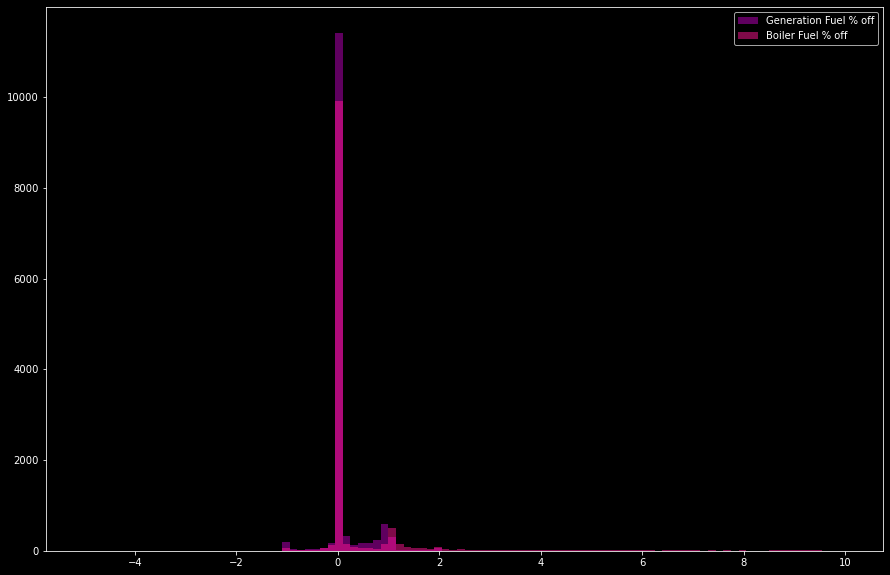

In [41]:

plt.hist(
    plant_test[
        (abs(plant_test.perc_gf) != np.inf)
        #& ~np.isclose(plant_test.perc_gf, 0)
    ].perc_gf,
    bins=100,
    range=(-5,10),
    alpha=.75,
    color='purple',
    label='Generation Fuel % off'
    
)

plt.hist(
    plant_test[
        (abs(plant_test.perc_bf) != np.inf)
       # & ~np.isclose(plant_test.perc_bf, 0)
    ].perc_bf,
    bins=100,
    range=(-5,10),
    alpha=.5,
    color='deeppink',
    label='Boiler Fuel % off'
)

plt.legend()
plt.title("")
plt.show()

# Examples!

In [15]:
#IDX_PM_FUEL= ['prime_mover_code', 'fuel_type'] # plus 'plant_id_eia', 'report_date' of course
# inputs
gens_ex = pd.DataFrame({
    'generator_id': ['A', 'B', 'C', 'D'],
    'unit_id_pudl': [1, 1, 2, 3],
    'prime_mover_code': ['GT', 'ST', 'GT', 'GT'],
    'energy_source_code_1': ['NG', 'NG', 'NG', 'NG'],
    'energy_source_code_2': ['DFO', np.nan, 'DFO', np.nan],
    'capacity_mw': [100, 50, 25, 10]
})
bf_ex = pd.DataFrame({
    'boiler_id': ['X1', 'Y1'],
    'fuel_type': ['NG', 'DFO'],
    'unit_id_pudl': [1, 1],
    'fuel_consumed_mmbtu': [8, 2]
})
gf_ex = pd.DataFrame({
    'prime_mover_code': 
        ['GT', 'ST', 'GT'],
    'fuel_type': 
        ['NG', 'NG', 'DFO'],
    'fuel_consumed_mmbtu': 
        [7, 2, 3]
})

## Interim Output
# stack the gens table with the different fuel types
gens_stacked_ex = pd.DataFrame({
    'generator_id': ['A', 'A', 'B', 'C', 'C', 'D'],
    'unit_id_pudl': [1, 1, 1, 2, 2, 3],
    'prime_mover_code': ['GT', 'GT', 'ST', 'GT', 'GT', 'GT'],
    'fuel_type': ['NG', 'DFO', 'NG', 'NG', 'DFO', 'NG']
})
# associate the generators w/ the gf table (mergeon IDX_PM_F)
# and calculate values (sums/groupbys)
gen_assoc_ex = pd.DataFrame({
    'generator_id': ['A', 'A', 'B', 'C', 'C', 'D'],
    'unit_id_pudl': [1, 1, 1, 2, 2, 3,],
    'prime_mover_code': 
        ['GT', 'GT',  'ST', 'GT', 'GT', 'GT'],
    'fuel_type': 
        ['NG', 'DFO', 'NG', 'NG', 'DFO', 'NG'],
    'capacity_mw': 
        [100,  100,   50,   25,   25,    10],
    # what we are trying to allocate
    # merge btwn gen_assoc & gf, by PM_F
    # Fuel totals on a per-pm-fuel basis
    'fuel_consumed_mmbtu_gf_tbl': 
        [7, 3, 2, 7, 3, 7],

    ########
    # sums/groupbys that we need before doing any of the assign-type calcs
    'capacity_mw_pm_fuel': 
        [135,  125,   50,   135,  125,   10],
    # (summed by PM)
    'fuel_consumed_mmbtu_gf_tbl_pm':
        [10, 10, 2, 10, 10, 10],
    # from gf table, summed by fuel
    'fuel_consumed_mmbtu_gf_tbl_fuel': 
        [9, 3, 9, 9, 3, 9],
    # reported by unit and fuel type in BF
    # merged into association table, broadcasting across prime mover
    'fuel_consumed_mmbtu_bf_tbl':
        [8, 2, 8, np.nan, np.nan, np.nan],
    'in_bf_tbl':
        [True, True, True, False, False, False],
    # sum of cap in [pm, fuel + exist_in_bf] group
    'capacity_mw_pm_fuel_in_bf_tbl_group':
        [100, 100, 50, 35, 35, 35],
})

In [16]:
#  gen_assoc tabl but only the records that don't exist in bf
# plus the calculated fields we need to generate the final fuel
not_in_bf_tbl = pd.DataFrame({
    ### columns from gen_assoc
    'generator_id': ['C', 'C', 'D'],
    'unit_id_pudl': [2, 2, 3,],
    'prime_mover_code': ['GT', 'GT', 'GT'],
    'fuel_type': ['NG', 'DFO', 'NG'],
    'capacity_mw': [25, 25, 10],
    # what we are trying to allocate
    # merge btwn gen_assoc & gf, by PM_F
    # Fuel totals on a per-pm-fuel basis
    'fuel_consumed_mmbtu_gf': 
        [7, 3, 7],
    
    ########
    # sums/groupbys that we need before doing any of the assign-type calcs
    # from bf table, summed by fuel
    'fuel_consumed_mmbtu_bf_fuel':
        [8, 2, 8],
    # from gf table, summed by fuel
    'fuel_consumed_mmbtu_gf_fuel': 
        [9, 3, 9],
    # sum of cap in [pm, fuel + exist_in_bf] group
    # total capacity in each pm fuel group
    'capacity_mw_pm_fuel_in_bf_tbl_group':
        [35, 25, 35],
    
    # what fuel should be assigned to these "not in bf" 
    # records based on fuel groupings?
    # fuel that should be allocated to the not-reporting-to-bf records
    # (the fuel in the gf tbl's fuel group - the fuel in the bf tbl's fuel group)
    # (fuel_consumed_mmbtu_gf_fuel - fuel_consumed_mmbtu_bf_fuel) / fuel_consumed_mmbtu_gf
    'fuel_consumed_mmbtu_not_in_bf': 
        [(9-8), (3-2), (9-8)],
    
    ### Get the frac_cap (used for allocating within gens that don't report to bf)
    # Portion of capacity for each PM_FUEL group
    # capacity_mw / capacity_mw_pm_fuel_in_bf_tbl_group
    'frac_cap':
        [25/35, 25/25, 10/35],
    
    # frac * fuel_consumed_mmbtu_gf
    'fuel_consumed_mmbtu':
        [(9-8) * (25/35), (3-2) * (35/35), (9-8) * (10/35)],
})

# aggregate the generator allocation to the units
not_in_bf_unit = pd.DataFrame({
    'unit_id_pudl': 
        [2, 3],
    'fuel_consumed_mmbtu':
        [1.71, 0.028]
})

# aggregate the bf table to the unit leve
bf_unit = pd.DataFrame({
    'unit_id_pudl': [1],
    'fuel_consumed_mmbtu': [10]
})

all_unit = pd.DataFrame({
    'unit_id_pudl': 
        [1, 2, 3],
    'fuel_consumed_mmbtu':
        [10, 1.714, 0.286]
})

In [17]:
assert(all_unit.fuel_consumed_mmbtu.sum() == gf_ex.fuel_consumed_mmbtu.sum())

### Allocating the boiler fuel data to generators
We don't need to do this if our end goal is to aggregate to the unit level... but it may be helpful for other contexts so I'm leaving this here for now. This exploration is not complete, but it was an attempt to allocate the boiler-fuel data to the generator level.

In [18]:
# beginning of unit
frac_df_in_bf = pd.DataFrame({
    'generator_id': ['A', 'A', 'B'],
    'unit_id_pudl': [1, 1, 1],
    'prime_mover_code': ['GT', 'GT', 'ST'],
    'fuel_type': ['NG', 'DFO', 'NG'],
    'capacity_mw': 
        [100, 100, 50],
    # reported by unit and fuel type in BF
    # merged into association table, broadcasting across prime mover
    'fuel_consumed_mmbtu_bf':
        [8, 2, 8],

    ########
    # we are going to equally allocate fuel burned within a unit
    # to the various generators (regardless of their prime mover)
    # based on capacity
    # sums/groupbys that we need before doing any of the assign-type calcs
    'capacity_mw_fuel_in_bf_tbl': 
        [150, 100, 150],
    # capacity_mw /capacity_mw_fuel_in_bf_tbl
    'frac_cap':
        [100/150, 100/100, 50/150],
    # fuel_consumed_mmbtu_bf * frac_cap
    'fuel_consumed_mmbtu':
        [8*(100/150), 2*(100/100), 8*(50/150)],
})

assert(frac_df_in_bf.fuel_consumed_mmbtu.sum() == bf_ex.fuel_consumed_mmbtu.sum())

## Explore Problem

In [9]:
fuel_diff_val = bf.fuel_consumed_mmbtu.sum() / gf.fuel_consumed_mmbtu.sum()
logger.info(f"{fuel_diff_val:.02%} fuel consumption missing from gen table")

52.64% fuel consumption missing from gen table


In [13]:
idx_cols_plant = ['plant_id_eia','report_date']
fuel_diff = (
    pd.merge(
        bf.groupby(by=idx_cols_plant)[['fuel_consumed_mmbtu']].sum(),
        gf.groupby(by=idx_cols_plant)[['fuel_consumed_mmbtu']].sum(),
        right_index=True,
        left_index=True,
        suffixes=('_bf','_gf'),
        how='outer'
    )
    .assign(
        fuel_diff_num=lambda x: x.fuel_consumed_mmbtu_gf.fillna(0) - x.fuel_consumed_mmbtu_bf.fillna(0),
        fuel_diff_rate=lambda x: x.fuel_consumed_mmbtu_bf.fillna(0)/ x.fuel_consumed_mmbtu_gf.fillna(0)
    )
    .merge(
        gens.groupby(by=idx_cols_plant)
        [['generator_id','prime_mover_code']]
        .nunique()
        .add_suffix('_count'),
        right_index=True,
        left_index=True,
        how='outer'
    )
    .reset_index()
)

diff_mask = (fuel_diff.fuel_diff_num.notnull()
    & (fuel_diff.fuel_diff_num != 0)
    & (~np.isclose(abs(fuel_diff.fuel_diff_rate), 1))
    & (~np.isclose(abs(fuel_diff.fuel_diff_rate), 0)))

logger.info(len(fuel_diff[fuel_diff.fuel_diff_num < 0]))
logger.info(len(fuel_diff[fuel_diff.fuel_diff_num >= 0]))
logger.info(len(fuel_diff[fuel_diff.fuel_diff_num.isnull()]))

diff_w_many_pms = fuel_diff[(fuel_diff.prime_mover_code_count > 1) & diff_mask]
diff_w_one_pm = fuel_diff[(fuel_diff.prime_mover_code_count == 1) & diff_mask]
logger.info(
    f"{len(diff_w_many_pms)/len(fuel_diff[diff_mask]):.02%} of records w/ gen v gen_fuel diff that have >1 prime mover")


3966
76515
58661
89.25% of records w/ gen v gen_fuel diff that have >1 prime mover
0.02% of records that have more net gen in net gen table


In [14]:
logger.info(
    f"{len(fuel_diff[fuel_diff.fuel_diff_rate > 1.00001])/len(fuel_diff):.02%} of records that have more net gen in net gen table"
)

0.15% of records that have more net gen in net gen table


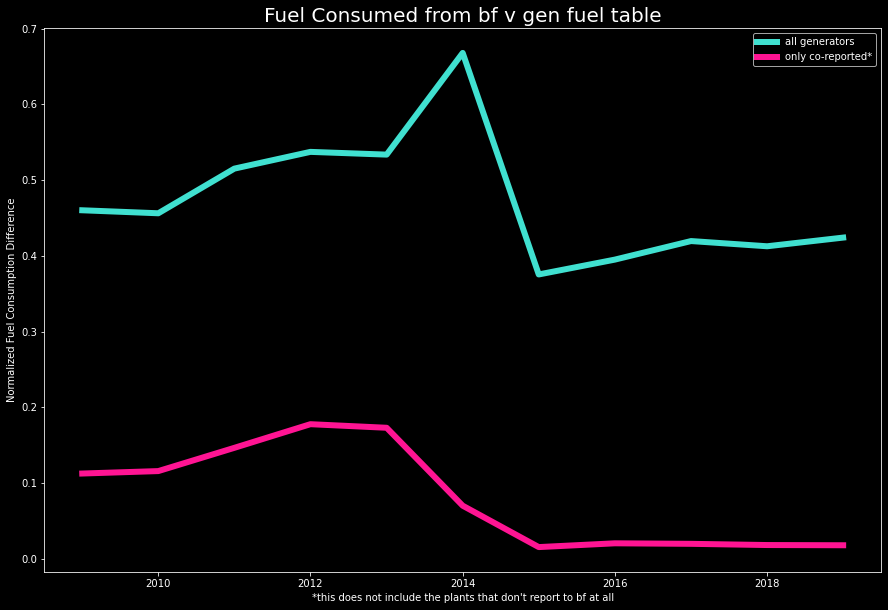

In [18]:
plt.plot((fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_diff_num
          /fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_consumed_mmbtu_gf),
         label='all generators', linewidth=6, color='turquoise'
        )
plt.plot((fuel_diff[(fuel_diff.fuel_consumed_mmbtu_bf.notnull())]
          .groupby(by='report_date',dropna=False).sum().fuel_diff_num
          /fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_consumed_mmbtu_gf
         ),
         label='only co-reported*', linewidth=6, color='deeppink'
        )

plt.legend()
plt.ylabel("Normalized Fuel Consumption Difference")
plt.xlabel("*this does not include the plants that don't report to bf at all")
plt.title("Fuel Consumed from bf v gen fuel table", size=20)
plt.show()

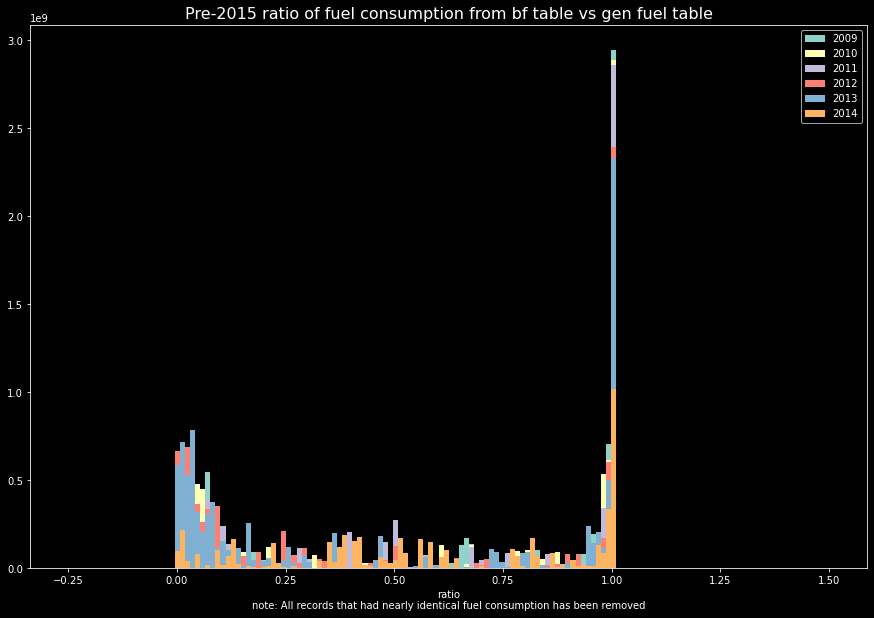

In [30]:
for year in range(2009,2015):
    df = fuel_diff[diff_mask & (fuel_diff.report_date.dt.year == year)]
    plt.hist(
        df.fuel_diff_rate,
        bins=150,
        range=(-.25,1.5),
        label=year,
        weights=abs(df.fuel_consumed_mmbtu_gf)
    )
plt.title("Pre-2015 ratio of fuel consumption from bf table vs gen fuel table", size=16)
plt.legend()
plt.xlabel("""ratio
note: All records that had nearly identical fuel consumption has been removed""")
plt.show()

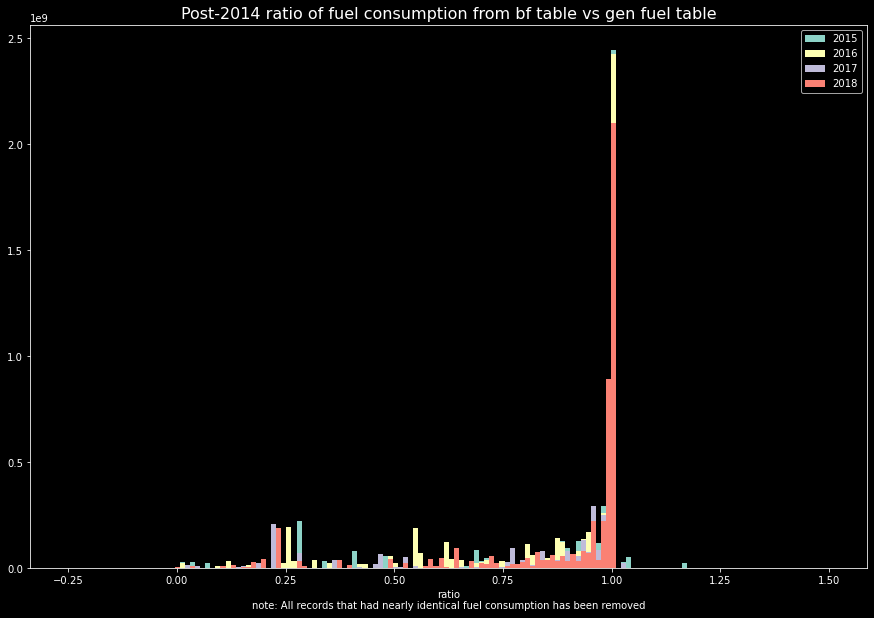

In [29]:
for year in range(2015,2019):
    df = fuel_diff[diff_mask & (fuel_diff.report_date.dt.year == year)]
    plt.hist(
        df.fuel_diff_rate,
        bins=150,
        range=(-.25,1.5),
        label=year,
        weights=abs(df.fuel_consumed_mmbtu_gf)
    )
plt.title("Post-2014 ratio of fuel consumption from bf table vs gen fuel table", size=16)
plt.legend()
plt.xlabel("""ratio
note: All records that had nearly identical fuel consumption has been removed""")
plt.show()